In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks, hilbert
from scipy.integrate import odeint

# === Load EEG data (replace with your path) ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/EEG.csv"
EEG = pd.read_csv(file_path)

real_data_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(real_data_path)


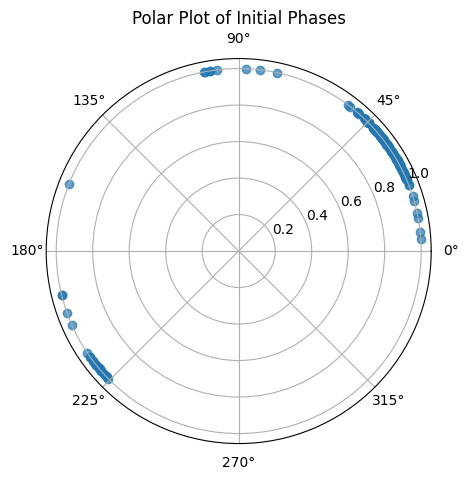

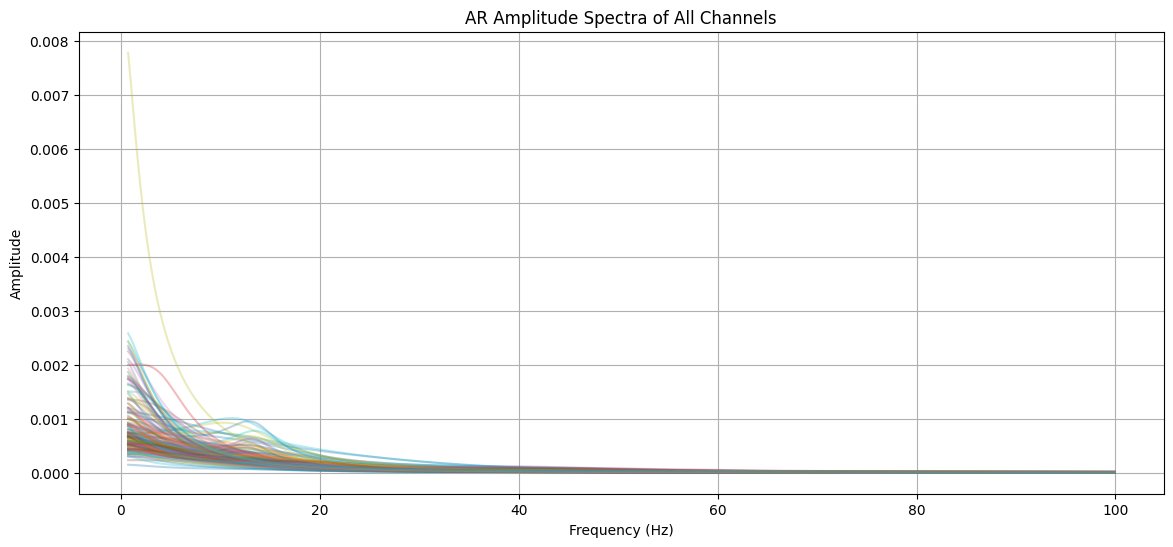

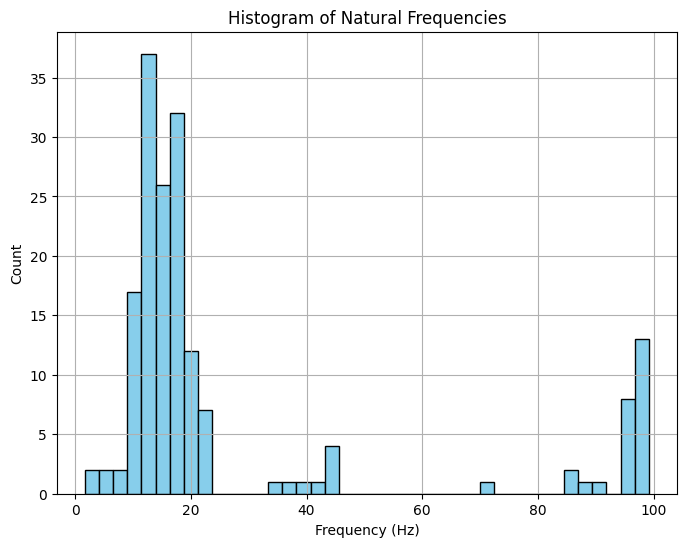

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from joblib import Parallel, delayed
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

# === Parameters ===
fs = 1000  # Hz
n_fft = 2048
fmin, fmax = 0.5, 100
EEG_segment = EEG.iloc[:27000]

# === AR feature extraction ===
def extract_ar_features(signal, fs, max_order=40, n_fft=2048, fmin=0.5, fmax=100):
    sel = ar_select_order(signal, maxlag=max_order, ic='bic', old_names=False)
    order = sel.ar_lags[-1] if len(sel.ar_lags) > 0 else max_order

    model = AutoReg(signal, lags=order, old_names=False).fit()
    coeffs = model.params[1:]
    noise_var = np.var(model.resid)

    # Roots and associated angles
    roots = np.roots(np.concatenate(([1], -coeffs)))
    roots = roots[np.abs(roots) < 1]
    angles = np.angle(roots)  # [-π, π]
    phases = np.mod(angles, 2 * np.pi)
    freqs = phases * fs / (2 * np.pi)

    # Filter within frequency range
    mask = (freqs >= fmin) & (freqs <= fmax)
    freqs_masked = freqs[mask]
    roots_masked = roots[mask]
    phases_masked = phases[mask]

    # Compute AR amplitude spectrum
    freq_grid = np.linspace(0, fs / 2, n_fft)
    w = 2 * np.pi * freq_grid / fs
    denom = np.abs(1 - np.sum(
        [coeffs[k] * np.exp(-1j * w * (k + 1)) for k in range(order)], axis=0))**2
    psd = noise_var / denom
    amp_spectrum = np.sqrt(psd)

    # Mask spectrum
    spectrum_mask = (freq_grid >= fmin) & (freq_grid <= fmax)
    freq_grid = freq_grid[spectrum_mask]
    amp_spectrum = amp_spectrum[spectrum_mask]

    # Natural frequency and phase from peak
    peaks, _ = find_peaks(amp_spectrum)
    if len(peaks) > 0:
        peak_idx = peaks[np.argmax(amp_spectrum[peaks])]
        natural_freq = freq_grid[peak_idx]
        natural_phase = 2 * np.pi * natural_freq / fs  # In radians (wrapped)
    else:
        natural_freq = np.sum(freq_grid * amp_spectrum) / np.sum(amp_spectrum)
        natural_phase = 2 * np.pi * natural_freq / fs

    return natural_freq, natural_phase, freq_grid, amp_spectrum

# === Extract from all EEG channels ===
results = Parallel(n_jobs=-1)(
    delayed(extract_ar_features)(EEG_segment[ch].values, fs)
    for ch in EEG_segment.columns
)

# === Unpack ===
natural_freqs, natural_phases, freq_grids, amp_spectra = zip(*results)
natural_freqs = np.array(natural_freqs) # Convert to radians
natural_phases = np.array(natural_phases)
natural_phases = (natural_phases * 2 * np.pi) % (2 * np.pi)

# === Optional: Polar plot of phases ===
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)
ax.scatter(natural_phases, np.ones_like(natural_phases), alpha=0.7)
ax.set_title("Polar Plot of Initial Phases")
plt.show()

# === Plot 1: All frequency spectra ===
plt.figure(figsize=(14, 6))
for fg, amp in zip(freq_grids, amp_spectra):
    plt.plot(fg, amp, alpha=0.3)
plt.title("AR Amplitude Spectra of All Channels")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# === Plot 2: Histogram of natural frequencies ===
plt.figure(figsize=(8, 6))
plt.hist(natural_freqs, bins=40, color='skyblue', edgecolor='black')
plt.title("Histogram of Natural Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count")
plt.grid(True)
plt.show()



Estimated g(omega): 0.0289
Critical coupling ε_c ≈ 22.0150


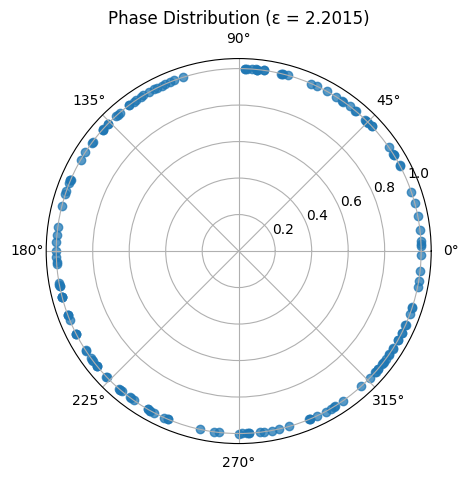

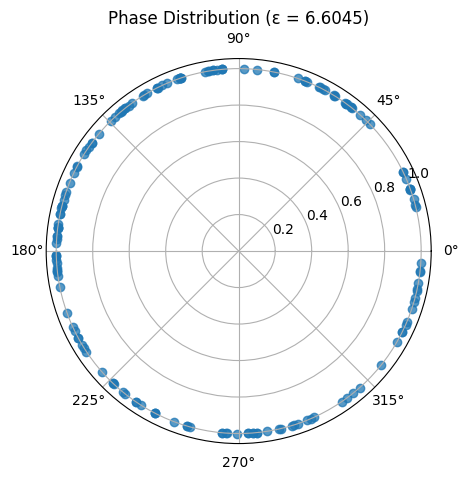

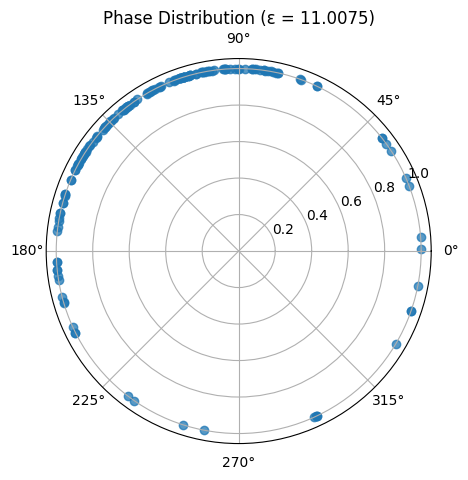

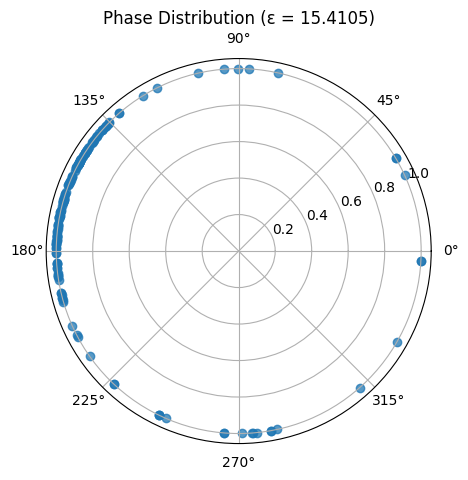

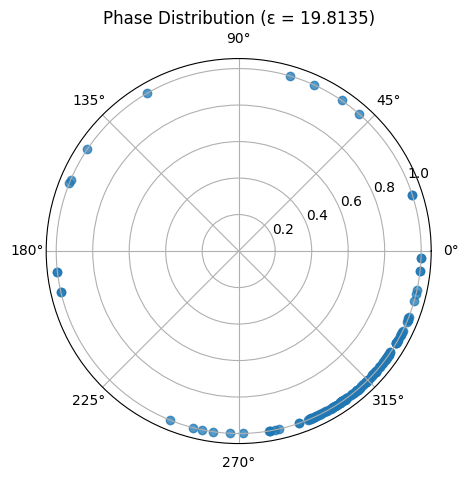

In [3]:
# Kuramoto model simulation with Hilbert-derived natural frequencies with critical epsilon
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks
from scipy.stats import gaussian_kde

# === Parameters ===
bins = 200  # Number of histogram bins # Focus on EEG band 
T_sim = 1500  # Number of time steps for simulation
dt = 0.01  # Time step size
N = len(EEG.columns)  # Number of EEG channels
fs = 1000  # Hz
n_fft = 2048
fmin, fmax = 0.5, 100
EEG_segment = EEG.iloc[:27000]

# === AR feature extraction ===
def extract_ar_features(signal, fs, max_order=40, n_fft=2048, fmin=0.5, fmax=100):
    sel = ar_select_order(signal, maxlag=max_order, ic='bic', old_names=False)
    order = sel.ar_lags[-1] if len(sel.ar_lags) > 0 else max_order

    model = AutoReg(signal, lags=order, old_names=False).fit()
    coeffs = model.params[1:]
    noise_var = np.var(model.resid)

    # Roots and associated angles
    roots = np.roots(np.concatenate(([1], -coeffs)))
    roots = roots[np.abs(roots) < 1]
    angles = np.angle(roots)  # [-π, π]
    phases = np.mod(angles, 2 * np.pi)
    freqs = phases * fs / (2 * np.pi)

    # Filter within frequency range
    mask = (freqs >= fmin) & (freqs <= fmax)
    freqs_masked = freqs[mask]
    roots_masked = roots[mask]
    phases_masked = phases[mask]

    # Compute AR amplitude spectrum
    freq_grid = np.linspace(0, fs / 2, n_fft)
    w = 2 * np.pi * freq_grid / fs
    denom = np.abs(1 - np.sum(
        [coeffs[k] * np.exp(-1j * w * (k + 1)) for k in range(order)], axis=0))**2
    psd = noise_var / denom
    amp_spectrum = np.sqrt(psd)

    # Mask spectrum
    spectrum_mask = (freq_grid >= fmin) & (freq_grid <= fmax)
    freq_grid = freq_grid[spectrum_mask]
    amp_spectrum = amp_spectrum[spectrum_mask]

    # Natural frequency and phase from peak
    peaks, _ = find_peaks(amp_spectrum)
    if len(peaks) > 0:
        peak_idx = peaks[np.argmax(amp_spectrum[peaks])]
        natural_freq = freq_grid[peak_idx]
        natural_phase = 2 * np.pi * natural_freq / fs  # In radians (wrapped)
    else:
        natural_freq = np.sum(freq_grid * amp_spectrum) / np.sum(amp_spectrum)
        natural_phase = 2 * np.pi * natural_freq / fs

    return natural_freq, natural_phase, freq_grid, amp_spectrum

# === Extract from all EEG channels ===
results = Parallel(n_jobs=-1)(
    delayed(extract_ar_features)(EEG_segment[ch].values, fs)
    for ch in EEG_segment.columns
)

# === Unpack ===
natural_freqs, natural_phases, freq_grids, amp_spectra = zip(*results)
natural_freqs = np.array(natural_freqs) # Convert to radians
natural_phases = np.array(natural_phases)
natural_phases = (natural_phases * 2 * np.pi) % (2 * np.pi)

omega = natural_freqs  # frequency vector

# === Step 2: Estimate g(omega) and critical epsilon ===
kde = gaussian_kde(omega)
density_values = kde.evaluate(omega)
g_omega = np.max(density_values)
epsilon_critical = 2 / (np.pi * g_omega)

print(f"Estimated g(omega): {g_omega:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical:.4f}")

# === Step 3: Simulate Kuramoto model ===
epsilons = np.linspace(0.1 * epsilon_critical, 0.9 * epsilon_critical, 5)

# === Simulation ===
for epsilon in epsilons:
    x = np.copy(natural_phases)
    phase_history = np.zeros((T_sim, N))
    phase_history[0] = x

    for t in range(1, T_sim):
        x_new = np.copy(x)
        for k in range(N):
            coupling_sum = np.sum(np.sin(x - x[k]))
            x_new[k] += dt * (omega[k] + (epsilon / N) * coupling_sum)
        x = x_new
        phase_history[t] = x

    time = np.arange(T_sim) * dt

    # === Plot 2: Final phase distribution in polar plot ===
    final_phases = phase_history[-1]
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.scatter(final_phases % (2*np.pi), np.ones_like(final_phases), alpha=0.75)
    ax.set_title(f'Phase Distribution (ε = {epsilon:.4f})')
    plt.show()

In [4]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.utils import resample

# Assuming `omega` is your array of natural frequencies
n_bootstraps = 1000
g_omega_values = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    omega_sample = resample(omega)
    kde = gaussian_kde(omega_sample)
    density_values = kde.evaluate(omega_sample)
    g_omega_values.append(np.max(density_values))

g_omega_values = np.array(g_omega_values)
g_omega_mean = np.mean(g_omega_values)
g_omega_std = np.std(g_omega_values)

epsilon_critical_values = 2 / (np.pi * g_omega_values)
epsilon_critical_mean = np.mean(epsilon_critical_values)
epsilon_critical_std = np.std(epsilon_critical_values)

print(f"Estimated g(omega): {g_omega_mean:.4f} ± {g_omega_std:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical_mean:.4f} ± {epsilon_critical_std:.4f}")


Estimated g(omega): 0.0291 ± 0.0028
Critical coupling ε_c ≈ 22.1138 ± 2.1014


In [5]:
# Kuramoto model simulation with Hilbert-derived natural frequencies with critical epsilon
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks
from scipy.stats import gaussian_kde

# === Parameters ===
bins = 200  # Number of histogram bins # Focus on EEG band 
T_sim = 5000  # Number of time steps for simulation
dt = 0.01  # Time step size
channels = EEG.columns
N = len(channels)
fs = 1000  # Hz
n_fft = 2048
fmin, fmax = 0.5, 100
EEG_segment = EEG.iloc[:27000]
epsilon = 0.5 * epsilon_critical

# === AR feature extraction ===
def extract_ar_features(signal, fs, max_order=40, n_fft=2048, fmin=0.5, fmax=100):
    sel = ar_select_order(signal, maxlag=max_order, ic='bic', old_names=False)
    order = sel.ar_lags[-1] if len(sel.ar_lags) > 0 else max_order

    model = AutoReg(signal, lags=order, old_names=False).fit()
    coeffs = model.params[1:]
    noise_var = np.var(model.resid)

    # Roots and associated angles
    roots = np.roots(np.concatenate(([1], -coeffs)))
    roots = roots[np.abs(roots) < 1]
    angles = np.angle(roots)  # [-π, π]
    phases = np.mod(angles, 2 * np.pi)
    freqs = phases * fs / (2 * np.pi)

    # Filter within frequency range
    mask = (freqs >= fmin) & (freqs <= fmax)
    freqs_masked = freqs[mask]
    roots_masked = roots[mask]
    phases_masked = phases[mask]

    # Compute AR amplitude spectrum
    freq_grid = np.linspace(0, fs / 2, n_fft)
    w = 2 * np.pi * freq_grid / fs
    denom = np.abs(1 - np.sum(
        [coeffs[k] * np.exp(-1j * w * (k + 1)) for k in range(order)], axis=0))**2
    psd = noise_var / denom
    amp_spectrum = np.sqrt(psd)

    # Mask spectrum
    spectrum_mask = (freq_grid >= fmin) & (freq_grid <= fmax)
    freq_grid = freq_grid[spectrum_mask]
    amp_spectrum = amp_spectrum[spectrum_mask]

    # Natural frequency and phase from peak
    peaks, _ = find_peaks(amp_spectrum)
    if len(peaks) > 0:
        peak_idx = peaks[np.argmax(amp_spectrum[peaks])]
        natural_freq = freq_grid[peak_idx]
        natural_phase = 2 * np.pi * natural_freq / fs  # In radians (wrapped)
    else:
        natural_freq = np.sum(freq_grid * amp_spectrum) / np.sum(amp_spectrum)
        natural_phase = 2 * np.pi * natural_freq / fs

    return natural_freq, natural_phase, freq_grid, amp_spectrum

# === Extract from all EEG channels ===
results = Parallel(n_jobs=-1)(
    delayed(extract_ar_features)(EEG_segment[ch].values, fs)
    for ch in EEG_segment.columns
)

# === Unpack ===
natural_freqs, natural_phases, freq_grids, amp_spectra = zip(*results)
natural_freqs = np.array(natural_freqs) # Convert to radians
natural_phases = np.array(natural_phases)
natural_phases = (natural_phases * 2 * np.pi) % (2 * np.pi)

initial_phases = np.array(natural_phases)

x = np.array(initial_phases)  # Initial phases (fixed during TLE calculation)

# === Step 2: Compute TLEs for each channel ===
TLEs = np.zeros(N)
for k in range(N):
    cos_sum = 0
    for j in range(N):
        if j != k:
            cos_sum += np.cos(x[j] - x[k])
    TLEs[k] = - (epsilon / N) * cos_sum

# === Step 3: Threshold TLEs to determine simulated epileptogenicity ===
# Stable (TLE ≤ 0): 1 = Epileptogenic
# Unstable (TLE > 0): 0 = Non-epileptogenic

# === Step 4: Load real labels from CSV ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(file_path)

Epileptogenic_simulated = (TLEs <= 0).astype(int)
Epileptogenic_sim = np.column_stack((channels, Epileptogenic_simulated.astype(str)))

# Ensure columns match EEG channels
Epileptogenic_real = np.column_stack((channels, df['Epileptogenic'].to_numpy().astype(str)))

# === Step 5: Cross-tabulation of simulation vs real labels ===
sim_vals = Epileptogenic_sim[:, 1].astype(int)
real_vals = Epileptogenic_real[:, 1].astype(int)

# Build 2x2 contingency matrix: rows = simulated, columns = real
cross_table = np.zeros((2, 2), dtype=int)
for s, r in zip(sim_vals, real_vals):
    cross_table[s, r] += 1

# Format using pandas for readability
df_cross = pd.DataFrame(cross_table,
                        index=['Sim=0 (Non-Epi)', 'Sim=1 (Epi)'],
                        columns=['Real=0 (Non-Epi)', 'Real=1 (Epi)'])

print("\nCross-tabulation Results using AR Model (Simulated vs Real Epileptogenicity):")
print(df_cross)



Cross-tabulation Results using AR Model (Simulated vs Real Epileptogenicity):
                 Real=0 (Non-Epi)  Real=1 (Epi)
Sim=0 (Non-Epi)                15            11
Sim=1 (Epi)                   104            41
